In [187]:
import numpy as np
from sklearn.manifold import TSNE
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [188]:
data = np.load("/sailhome/ethanchi/structural-probes/relationOutputs/all.npy") 
labels = np.load("/sailhome/ethanchi/structural-probes/relationOutputs/allY.npy")
extra = np.load("/sailhome/ethanchi/structural-probes/relationOutputs/all-data.npy")

print("Finished loading data.")
print(labels)
print(f"There are {np.unique(labels).shape[0]} unique labels.")
print(data.shape)


Finished loading data.
['ar-nsubj' 'ar-case' 'ar-nummod' ... 'zh-advmod' 'zh-obj' 'zh-punct']
There are 335 unique labels.
(199849, 32)


In [189]:
USE_PRECISE_LABELS = False
if not USE_PRECISE_LABELS:
  remove_colon = np.vectorize(lambda x: x if ':' not in x else x.split(':')[0])
  labels = remove_colon(labels)

In [190]:
ONLY_LANG = True
if ONLY_LANG:
  is_lang = np.vectorize(lambda x: x.startswith('en') or x.startswith('fr'))
  indices = is_lang(labels)
  data = data[indices]
  labels = labels[indices]
  extra = extra[indices]

In [191]:
### TRAINING DATA

holdout_lang = "fr"

is_holdout_lang = np.vectorize(lambda x: x.startswith(holdout_lang))

train_data = data[~is_holdout_lang(labels)]
train_labels = labels[~is_holdout_lang(labels)]
train_extra = data[~is_holdout_lang(labels)]

test_data = data[is_holdout_lang(labels)]
test_labels = labels[is_holdout_lang(labels)]
test_extra = extra[is_holdout_lang(labels)]

print(f"There are {train_data.shape[0]} train examples and {test_data.shape[0]} test examples.")

There are 23146 train examples and 33182 test examples.


In [192]:
  
## REMOVE LANG INFORMATION
remove_lang_info = np.vectorize(lambda x: x.split('-')[1])
train_labels = remove_lang_info(train_labels)
test_labels = remove_lang_info(test_labels)

In [193]:
NUM_CLUSTERS = 60
TRAINING_SIZE = 20000

print(f"Training on {TRAINING_SIZE / train_data.shape[0] * 100:.3f}% of available data.")

kmeans = KMeans(n_clusters=NUM_CLUSTERS)

data_to_fit = train_data[np.random.randint(low=0, high=train_data.shape[0], size=TRAINING_SIZE)]
kmeans.fit(data_to_fit)
train_cluster_identities = kmeans.predict(train_data)
test_cluster_identities = kmeans.predict(test_data)

print("Finished training.")

Training on 86.408% of available data.
Finished training.


In [194]:
## get majority label per-cluster

clusters_to_labels = {}
clusters_to_sureness = {}
for cluster in np.unique(train_cluster_identities):
  num = np.where(train_cluster_identities == cluster)[0].shape[0]
  cluster_labels = train_labels[train_cluster_identities == cluster]
  cl_labels, counts = np.unique(cluster_labels, return_counts=True)
  best_label = cl_labels[np.argmax(counts)]
  print(f"{cluster}\t{num}", end="\t")
  top_labels = cl_labels[np.argsort(-counts)]
  top_counts = counts[np.argsort(-counts)] / num * 100
  print("\t".join(f"{top_labels[i]:<8}\t{top_counts[i]:.2f}%" for i in range(min(3, top_labels.shape[0]))), end="\t")
  sureness = top_counts[0] / top_counts[1] if top_labels.shape[0] > 1 else 3000
  print(f"{sureness:7.2f}")
  clusters_to_sureness[cluster] = sureness
  clusters_to_labels[cluster] = best_label



0	551	obj     	63.52%	obl     	12.52%	xcomp   	7.80%	   5.07
1	481	det     	99.38%	amod    	0.21%	case    	0.21%	 478.00
2	613	nsubj   	96.74%	advmod  	0.65%	punct   	0.65%	 148.25
3	511	amod    	61.84%	compound	18.59%	advmod  	7.24%	   3.33
4	267	det     	51.69%	nsubj   	10.49%	punct   	10.49%	   4.93
5	256	conj    	35.94%	parataxis	19.14%	punct   	10.55%	   1.88
6	240	case    	34.17%	cop     	25.83%	aux     	16.67%	   1.32
7	433	punct   	99.77%	advmod  	0.23%	 432.00
8	290	nmod    	27.59%	obl     	27.24%	advmod  	16.55%	   1.01
9	607	amod    	80.07%	advmod  	7.25%	compound	5.93%	  11.05
10	371	cop     	54.72%	aux     	41.24%	case    	0.81%	   1.33
11	361	nummod  	25.21%	det     	20.22%	amod    	16.90%	   1.25
12	333	conj    	17.12%	obl     	16.52%	acl     	12.61%	   1.04
13	621	cc      	94.52%	punct   	1.45%	conj    	1.29%	  65.22
14	372	conj    	33.33%	advcl   	7.80%	acl     	6.99%	   4.28
15	154	conj    	29.87%	punct   	24.68%	advcl   	9.09%	   1.21
16	411	aux     	91.97%	compound	

['punct' 'det' 'advmod' ... 'det' 'nmod' 'punct']
['punct' 'det' 'appos' ... 'det' 'obl' 'punct']
Test Accuracy: 58.137%
0	  5.07    42.03%
1	478.00    96.82%
2	148.25    54.07%
3	  3.33    44.62%
4	  4.93    46.29%
5	  1.88    37.98%
6	  1.32    35.12%
7	432.00    99.52%
8	  1.01    40.97%
9	 11.05    77.50%
10	  1.33    25.67%
11	  1.25    39.37%
12	  1.04    20.16%
13	 65.22    93.00%
14	  4.28    30.52%
15	  1.21    36.49%
16	 54.00    17.11%
17	  1.01    30.61%
18	 26.15    94.36%
19	  2.46    68.08%
20	  1.80     0.00%
21	  4.35    34.23%
22	  3.24    20.45%
23	 12.61    92.13%
24	 92.00    97.97%
25	569.00    98.35%
26	  1.25    41.19%
27	  3.56    16.37%
28	  3.77     0.00%
29	  1.01    46.10%
30	  2.99    59.69%
31	  1.00    14.82%
32	  3.62    75.59%
33	 74.75     2.52%
34	  3.09    46.22%
35	  1.24    23.09%
36	  9.59    47.67%
37	 53.00    92.35%
38	  5.63    72.81%
39	  1.12    15.35%
40	471.00   100.00%
41	  3.13     5.60%
42	  1.51    27.79%
43	  1.85    78.89%
44	  2.00

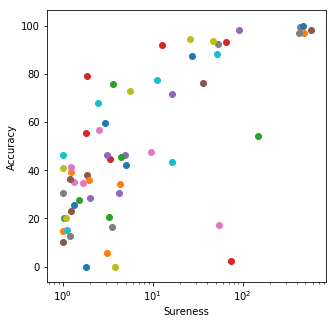

In [195]:
identity_to_label = np.vectorize(lambda x: clusters_to_labels[x])
predicted_labels = identity_to_label(test_cluster_identities)
print(predicted_labels)
print(test_labels)

numRight = len(np.where(predicted_labels == test_labels)[0])
totalNum = predicted_labels.shape[0]
accuracy = numRight / totalNum * 100

print(f"Test Accuracy: {accuracy:.3f}%")


plt.figure(figsize=(5, 5))
plt.xscale("log")
for cluster in np.unique(train_cluster_identities):
  try:
    cluster_accuracy = len(np.where((test_cluster_identities == cluster) & (predicted_labels == test_labels))[0]) / len(np.where(test_cluster_identities == cluster)[0]) * 100
  except ZeroDivisionError:
    continue
  print(f"{cluster}\t{clusters_to_sureness[cluster]:6.2f} {cluster_accuracy:8.2f}%")
  plt.scatter(clusters_to_sureness[cluster], cluster_accuracy)

plt.xlabel('Sureness')
plt.ylabel('Accuracy')
plt.show()

In [57]:
unique_labels, counts = np.unique(labels, return_counts=True)

mapping = dict(zip(unique_labels, counts))
mapping = sorted(mapping.items(), key=lambda kv: -kv[1])
print("\n".join("\t".join(str(y) for y in x) for x in mapping))

remove_langs = np.vectorize(lambda x: x.replace('en-', '').replace('fr-', ''))
base_labels = remove_langs(labels)

base_unique_labels, base_counts = np.unique(base_labels, return_counts=True)

base_mapping = dict(zip(base_unique_labels, base_counts))
base_mapping = sorted(base_mapping.items(), key=lambda kv: -kv[1])
print("\n".join("\t".join(str(y) for y in x) for x in base_mapping))


punct	25421
case	24792
nmod	20751
det	16432
nsubj	14222
obl	12052
amod	11691
obj	9838
advmod	8311
conj	7346
cc	6963
mark	5780
acl	4614
flat	4479
aux	3816
nummod	3401
compound	3216
cop	2933
appos	2340
advcl	2272
xcomp	2137
ccomp	2123
fixed	1578
parataxis	782
dep	776
iobj	404
expl	332
csubj	274
clf	200
discourse	184
root	116
list	75
orphan	72
goeswith	47
vocative	42
dislocated	28
reparandum	9
punct	25421
case	24792
nmod	20751
det	16432
nsubj	14222
obl	12052
amod	11691
obj	9838
advmod	8311
conj	7346
cc	6963
mark	5780
acl	4614
flat	4479
aux	3816
nummod	3401
compound	3216
cop	2933
appos	2340
advcl	2272
xcomp	2137
ccomp	2123
fixed	1578
parataxis	782
dep	776
iobj	404
expl	332
csubj	274
clf	200
discourse	184
root	116
list	75
orphan	72
goeswith	47
vocative	42
dislocated	28
reparandum	9


In [20]:
print(cluster_identities[labels == 'en-nsubj'])
print(cluster_identities[labels == 'en-nsubj'].shape)
print(np.bincount(cluster_identities[labels == 'en-nsubj']))

u_labels, counts = np.unique(cluster_identities, return_counts=True)
print(dict(zip(u_labels, counts)))

for label in np.unique(labels):
  print("{: <10}".format(label), end="\t")
  print("".join(["{:4d}".format(x) for x in np.bincount(cluster_identities[labels == label], minlength=NUM_CLUSTERS)]))

[17 61 52 ... 61 61 63]
(2143,)
[  8  13  11   2   3   0   3   0   2   0   0  30   0   2   1  32   5  58
  16  16  15   0   2   0   1   9  27 100   5  30  14  20   1  27  36   0
   0   2  38  15   5   0   5  14   2  17   0   0   9   4   8   0   4   4
   1  13   6   1   9  84   0 430   2 946   0   0   9  12  14]
{0: 1742, 1: 3326, 2: 4391, 3: 4055, 4: 3306, 5: 1779, 6: 3433, 7: 2110, 8: 2213, 9: 2007, 10: 2390, 11: 2726, 12: 4074, 13: 3040, 14: 2347, 15: 3236, 16: 3174, 17: 5028, 18: 3213, 19: 3269, 20: 1428, 21: 2189, 22: 3399, 23: 3959, 24: 2093, 25: 2481, 26: 2336, 27: 2948, 28: 2709, 29: 3147, 30: 1918, 31: 2844, 32: 2911, 33: 2811, 34: 1993, 35: 3915, 36: 1615, 37: 2495, 38: 2676, 39: 3111, 40: 1003, 41: 3126, 42: 1008, 43: 1991, 44: 3270, 45: 3377, 46: 5970, 47: 2390, 48: 1561, 49: 2347, 50: 2583, 51: 2365, 52: 3304, 53: 1923, 54: 5028, 55: 4236, 56: 4113, 57: 2357, 58: 3968, 59: 2383, 60: 439, 61: 4231, 62: 2097, 63: 2885, 64: 3206, 65: 1631, 66: 3517, 67: 3404, 68: 3834, 69: 246

en-obj    	   3 159  17   2   3   0   3   0   8   1   0   8  11   0   0  30  21 487   3  28   0   0   3   1   0   7   3  10   6  82  44   4   0   3   0   0   0   3   3   3   0   0   0   0   6  63   0   2   6   8   3  10   6   2   0   9   1   4  13   3   0   8   3  13   0   0  72   5  41   0
en-obl    	   5  45  19   1   3   7   0   0   4   3   0  47   0   1  11  55  69  61   3  16  12   0  17   0  10   3  11   6   3  77  23  14  10  15  13   1   0   2  22   3   2   0   4   0  52  54   1   1   4  28   5  31  10  34   2   7   3  27  13   0   0   4  56   6  16   9  62  14 114   0
en-orphan 	   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
en-parataxis	   1   2   0   0   0  18   0   0   0   0   1   0   1   2   0   1  32   0   0   1   3   0   1   0  66   1   0   

fr-dislocated	   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
fr-expl   	   0   1   0   0   1   0   0   0   1   0   0   0   0   0   0   1   0   1   0   0   0   0   6   0   0   0   0   0   0   0   4   0   2  44   0   0   0   0   0   0   0   0   0   0   1   0  50  68   2   0   0   0   0   0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0   0
fr-fixed  	   0  47   2   0   2   0   1   0  46   0   0   2   5   0   9   0   0   2   0   0   0   0   3   6   0  11   0   3   7   0   8   0   4   1   0   0   0   1   1   3   0   0   0   0   0   6   2  44  10   0  18   1   2   2   0   2   2   0  30   0   0   0   4   7   2   0   1   1   0   1
fr-flat   	   2  38  19  12   0   0   1   0   0   0   0   5   1   0   2   4   1   4   0   0   0   0   0   0   0   2   2  

In [ ]:
## DEPENDENCY PARSER



In [22]:
NUM_TO_DRAW = 100

for cluster in u_labels:
  word_pairs = pairs_data[kmeans.labels_ == cluster]
  print("Cluster {} ({} words)".format(cluster, word_pairs.shape[0]))
  print(kmeans.cluster_centers_[cluster])
  trimmedLabels = labels[kmeans.labels_ == cluster]
  cluster_labels, counts = np.unique(trimmedLabels, return_counts=True)
  print(dict([kv for kv in zip(cluster_labels, counts) if kv[1] > 20]))
  pca = PCA(n_components=2)
  pca_data = pca.fit_transform(word_pairs.reshape(-1, 32))
  print(np.sum(pca.explained_variance_))
  pca_data = pca_data.reshape(-1, 2, 2)
  

  plt.figure(figsize=(10, 10))

  is_src = np.vectorize(lambda x: 'en' in x)
  is_dest = np.vectorize(lambda x: 'fr' in x)

  
  to_draw_src = pca_data[is_src(trimmedLabels)]
  to_draw_dest = pca_data[is_dest(trimmedLabels)]

  indices_to_examine_src = np.random.randint(to_draw_src.shape[0], size=NUM_TO_DRAW)
  indices_to_examine_dest = np.random.randint(to_draw_dest.shape[0], size=NUM_TO_DRAW)
  
  to_draw_src = to_draw_src[indices_to_examine_src]
  to_draw_dest = to_draw_dest[indices_to_examine_dest]
  
  
  for row in to_draw_src:
    plt.arrow(row[0][0], row[0][1], row[1][0] - row[0][0], row[1][1] - row[0][1], color='green', head_width=0.025, head_length=0.05, alpha=0.25)
  for row in to_draw_dest:
    plt.arrow(row[0][0], row[0][1], row[1][0] - row[0][0], row[1][1] - row[0][1], color='blue', head_width=0.025, head_length=0.05, alpha=0.1)
  
  plt.scatter(to_draw_src[:, 0, 0], to_draw_src[:, 0, 1], c='r', label='en-subj', s=10, alpha=1)
  plt.scatter(to_draw_src[:, 1, 0], to_draw_src[:, 1, 1], c='green', label='en-verb', s=10, alpha=1)

  plt.scatter(to_draw_dest[:, 0, 0], to_draw_dest[:, 0, 1], c='purple', label='fr-subj', s=10, alpha=1)
  plt.scatter(to_draw_dest[:, 1, 0], to_draw_dest[:, 1, 1], c='blue', label='fr-verb', s=10, alpha=1)

  plt.show()
    
    
pca_data = pca_data.reshape(-1, 2, 2)

# ROW_TO_CHECK = 57
# pca_first_test = pca.transform(trimmedData[ROW_TO_CHECK][1].reshape(1, -1)).squeeze()
# assert np.allclose(pca_first_test, pca_data[ROW_TO_CHECK][1])

print(pca_data.shape)

NameError: name 'pairs_data' is not defined

In [33]:
kmeans_all = KMeans(n_clusters=NUM_CLUSTERS)

kmeans_all.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=70, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)